# Import Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
import warnings
warnings.filterwarnings("ignore")

# Read Datasets

In [61]:
train_url="https://raw.githubusercontent.com/sotirischatzimiltis/MscThesis/main/NSLKDD/KDDTrain.txt"
test_url= "https://raw.githubusercontent.com/sotirischatzimiltis/MscThesis/main/NSLKDD/KDDTest.txt"
TRAIN_FILE="KDDTrain.txt"
TEST_FILE="KDDTest.txt"
![ -f "$TRAIN_FILE" ] && echo "$TRAIN_FILE exists" || wget "$train_url"
![ -f "$TEST_FILE" ] && echo "$TEST_FILE exists" || wget "$test_url"

KDDTrain.txt exists
KDDTest.txt exists


In [62]:
dataset_train = pd.read_csv("KDDTrain.txt", sep=",",header =None)
dataset_train = dataset_train.iloc[:,:-1] # remove difficulty column

In [63]:
dataset_test = pd.read_csv("KDDTest.txt",sep=",",header=None)
dataset_test = dataset_test.iloc[:,:-1] # remove difficulty column

Sample View of Training and Test datasets

In [64]:
dataset_train.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [65]:
dataset_test.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan


Columns names of Training and Test Datasets

In [66]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

Shape of Training and Test Datasets

In [67]:
print("Shape of Training Dataset:", dataset_train.shape)
print("Shape of Testing Dataset:", dataset_test.shape)

Shape of Training Dataset: (125973, 42)
Shape of Testing Dataset: (22544, 42)


Columns Assignment

In [68]:
dataset_train.columns = col_names # append labels
dataset_test.columns = col_names 

Labels of Training and Test Datasets

In [69]:
#label distribution of Training set and testing set
print('Label distribution Training set:')
print(dataset_train['label'].value_counts())
train_labels = dataset_train['label'].unique()
print()
print('Label distribution Test set:')
print(dataset_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


# Data Pre-processing

## Handle categorical features

In [70]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in dataset_train.columns:
    if dataset_train[col_name].dtypes == 'object' :
        unique_cat = dataset_train[col_name].nunique()
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

# Test set
print('Test set:')
for col_name in dataset_test.columns:
    if dataset_test[col_name].dtypes == 'object' :
        unique_cat = len(dataset_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories
Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


One-hot-Encoding

In [71]:
one_hot_encoder = preprocessing.OneHotEncoder() # create one hot encoder

Protocol Type

In [72]:
# fit one hot encoder
one_hot_encoder.fit(dataset_train['protocol_type'].values.reshape(-1,1))

#train dataset
train_transform = one_hot_encoder.transform(dataset_train['protocol_type'].values.reshape(-1,1)) 
train_transform = train_transform.toarray()
train_df = pd.DataFrame(train_transform, columns = one_hot_encoder.get_feature_names_out())
del dataset_train['protocol_type']
dataset_train = pd.concat([dataset_train,train_df], axis=1)

#test dataset
test_transform = one_hot_encoder.transform(dataset_test['protocol_type'].values.reshape(-1,1)) 
test_transform = test_transform.toarray()
test_df = pd.DataFrame(test_transform , columns = one_hot_encoder.get_feature_names_out())
del dataset_test['protocol_type']
dataset_test = pd.concat([dataset_test,test_df], axis=1)

Service 

In [73]:
# fit one hot encoder
one_hot_encoder.fit(dataset_train['service'].values.reshape(-1,1))

# train dataset
train_transform = one_hot_encoder.transform(dataset_train['service'].values.reshape(-1,1)) 
train_transform = train_transform.toarray()
train_df = pd.DataFrame(train_transform, columns = one_hot_encoder.get_feature_names_out())
del dataset_train['service']
dataset_train = pd.concat([dataset_train,train_df], axis=1)

# test dataset
test_transform = one_hot_encoder.transform(dataset_test['service'].values.reshape(-1,1)) 
test_transform = test_transform.toarray()
test_df = pd.DataFrame(test_transform , columns = one_hot_encoder.get_feature_names_out())
del dataset_test['service']
dataset_test = pd.concat([dataset_test,test_df], axis=1)

Flag

In [74]:
# fit one hot encoder
one_hot_encoder.fit(dataset_train['flag'].values.reshape(-1,1))

# train dataset
train_transform = one_hot_encoder.transform(dataset_train['flag'].values.reshape(-1,1)) 
train_transform = train_transform.toarray()
train_df = pd.DataFrame(train_transform, columns = one_hot_encoder.get_feature_names_out())
del dataset_train['flag']
dataset_train = pd.concat([dataset_train,train_df], axis=1)

# test dataset
test_transform = one_hot_encoder.transform(dataset_test['flag'].values.reshape(-1,1)) 
test_transform = test_transform.toarray()
test_df = pd.DataFrame(test_transform , columns = one_hot_encoder.get_feature_names_out())
del dataset_test['flag']
dataset_test = pd.concat([dataset_test,test_df], axis=1)

In [75]:
print("Shape of Training Dataset:", dataset_train.shape)
print("Shape of Testing Dataset:", dataset_test.shape)

Shape of Training Dataset: (125973, 123)
Shape of Testing Dataset: (22544, 123)


In [76]:
dataset_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,x0_REJ,x0_RSTO,x0_RSTOS0,x0_RSTR,x0_S0,x0_S1,x0_S2,x0_S3,x0_SF,x0_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Binary Classification Dataset

In [77]:
temp = dataset_test['label'].apply(lambda x: any(k in x for k in train_labels)) 
dataset_test_known = dataset_test[temp]
dataset_test_unknown = dataset_test[~temp]

In [78]:
print(dataset_test_known)

       duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0             0          0          0     0               0       0    0   
1             0          0          0     0               0       0    0   
2             2      12983          0     0               0       0    0   
5             0        267      14515     0               0       0    0   
6             0       1022        387     0               0       0    0   
...         ...        ...        ...   ...             ...     ...  ...   
22538         0       1032          0     0               0       0    0   
22539         0        794        333     0               0       0    0   
22540         0        317        938     0               0       0    0   
22541         0      54540       8314     0               0       0    2   
22542         0         42         42     0               0       0    0   

       num_failed_logins  logged_in  num_compromised  ...  x0_REJ  x0_RSTO  \
0        

In [79]:
print(dataset_test_unknown)

       duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
3             0         20          0     0               0       0    0   
4             1          0         15     0               0       0    0   
10            0          0          0     0               0       0    0   
21            0          0          0     0               0       0    0   
30          805      76944          1     0               0       0    0   
...         ...        ...        ...   ...             ...     ...  ...   
22517      7498          0         44     0               0       0    0   
22519      8209          0         15     0               0       0    0   
22525      2064      55744          0     0               0       0    0   
22537         1       2599        293     0               0       0    0   
22543         0          0          0     0               0       0    0   

       num_failed_logins  logged_in  num_compromised  ...  x0_REJ  x0_RSTO  \
3        

Split features and labels

In [80]:
x_train = dataset_train.drop('label',1)
col_names = x_train.columns
y_train = dataset_train.label
# replace all types of attacks , to value 'attack' 
y_train = np.where(y_train=='normal', 'normal', 'attack')
y_train = np.where(y_train=='normal', 0,1)

In [81]:
x_test = dataset_test.drop('label',1)
y_test = dataset_test.label
y_test = np.where(y_test=='normal', 'normal', 'attack')
y_test = np.where(y_test=='normal', 0,1)


In [82]:
x_test_known = dataset_test_known.drop('label',1)
y_test_known = dataset_test_known.label
y_test_known = np.where(y_test_known=='normal', 'normal', 'attack')
y_test_known = np.where(y_test_known=='normal', 0,1)

x_test_unknown = dataset_test_unknown.drop('label',1)
y_test_unknown = dataset_test_unknown.label
y_test_unknown = np.where(y_test_unknown=='normal', 'normal', 'attack')
y_test_unknown = np.where(y_test_unknown=='normal', 0,1)

Scaling

In [83]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_test_known = scaler.transform(x_test_known)
x_test_unknown = scaler.transform(x_test_unknown)

## Save initial dataset csv

In [84]:
x_train = pd.DataFrame(x_train)
x_train.columns= col_names
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train,y_train]
train_final_binary = pd.concat(train_frame,axis=1)
train_final_binary.to_csv('train_binary.csv',index = False)

In [85]:
x_test = pd.DataFrame(x_test)
x_test.columns= col_names
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_test,y_test]
test_binary = pd.concat(test_frame,axis=1)
test_binary.to_csv('test_binary.csv',index = False)

In [86]:
x_test_known = pd.DataFrame(x_test_known)
x_test_known.columns= col_names
y_test_known = pd.DataFrame(y_test_known)
y_test_known.columns = ['label']
test_frame = [x_test_known,y_test_known]
test_known_binary = pd.concat(test_frame,axis=1)
test_known_binary.to_csv('test_known_binary.csv',index = False)

In [87]:
x_test_unknown = pd.DataFrame(x_test_unknown)
x_test_unknown.columns= col_names
y_test_unknown = pd.DataFrame(y_test_unknown)
y_test_unknown.columns = ['label']
test_frame = [pd.DataFrame(x_test_unknown),pd.DataFrame(y_test_unknown)]
test_unknown_binary = pd.concat(test_frame,axis=1)
test_unknown_binary.to_csv('test_unknown_binary.csv',index = False)

## PCA

In [88]:
from sklearn.decomposition import PCA # import pca

Text(0, 0.5, 'Explained variance (%)')

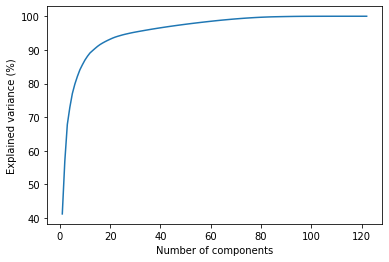

In [89]:
# plot the variance explanation of the 29 components needed to cover 95% initial data variance 
pca = PCA(None)
pca.fit(x_train)
components = len(pca.explained_variance_ratio_)
plt.plot(range(1,components+1), 
np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

In [90]:
# Make an instance of the Model
pca = PCA(.95) # 0.95: means we want 95% of data variance

In [91]:
pca.fit(x_train)

PCA(n_components=0.95)

In [92]:
print(pca.n_components_)

29


In [93]:
x_train_pca = pca.transform(x_train)  # perform pca
x_testall= pca.transform(x_test)
x_test_pca= pca.transform(x_test_known)
x_test_un_pca= pca.transform(x_test_unknown)

In [94]:
#min max scale again
scaler.fit(x_train_pca)
x_train_pca = scaler.transform(x_train_pca)
x_testall = scaler.transform(x_testall)
x_test_pca = scaler.transform(x_test_pca)
x_test_un_pca = scaler.transform(x_test_un_pca)

In [95]:
x_train_pca = pd.DataFrame(x_train_pca)
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_pca,y_train]
train_final_pca = pd.concat(train_frame,axis=1)
train_final_pca.to_csv('train_pca.csv',index = False)

In [96]:
x_testall = pd.DataFrame(x_testall)
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_testall,y_test]
testall = pd.concat(test_frame,axis=1)
testall.to_csv('test_pca.csv',index = False)

In [97]:
x_test_pca = pd.DataFrame(x_test_pca)
y_test_known = pd.DataFrame(y_test_known)
y_test_known.columns = ['label']
test_frame = [x_test_pca,y_test_known]
test_known_pca = pd.concat(test_frame,axis=1)
test_known_pca.to_csv('test_known_pca.csv',index = False)

In [98]:
x_test_un_pca = pd.DataFrame(x_test_un_pca)
y_test_unknown = pd.DataFrame(y_test_unknown)
y_test_unknown.columns = ['label']
test_frame = [x_test_un_pca,y_test_unknown]
test_unknown_pca = pd.concat(test_frame,axis=1)
test_unknown_pca.to_csv('test_unknown_pca.csv',index = False)

## Random Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3,
                                 bootstrap=True, n_jobs=-1,
                                 random_state=0)
rf.fit(x_train.values, y_train.values.ravel())

feature_imp = pd.Series(rf.feature_importances_, 
                        index=x_train.columns).sort_values(ascending=False)

In [100]:
for i in range(0,len(feature_imp)):
    print(i,end =" ")
    print(feature_imp.index[i],end = ": ")
    print(feature_imp[i])

0 same_srv_rate: 0.10797313669892639
1 srv_serror_rate: 0.0927994949619933
2 diff_srv_rate: 0.0919401117549538
3 x0_SF: 0.08394789689890068
4 logged_in: 0.08276537445018615
5 dst_host_srv_serror_rate: 0.0566509307222697
6 dst_host_same_srv_rate: 0.055308757751561445
7 dst_host_diff_srv_rate: 0.05349167583734105
8 serror_rate: 0.041709859298370816
9 dst_host_srv_count: 0.038481757797788944
10 x0_S0: 0.03538315906808305
11 count: 0.02954813351125355
12 dst_host_same_src_port_rate: 0.027738478359165625
13 x0_private: 0.021562332300889792
14 x0_icmp: 0.01974595284209636
15 x0_http: 0.017885054781750755
16 dst_host_serror_rate: 0.01784472198197527
17 dst_host_srv_diff_host_rate: 0.015608223289193862
18 rerror_rate: 0.014108252845520879
19 dst_host_srv_rerror_rate: 0.012530129816415343
20 x0_eco_i: 0.012252985670118401
21 srv_diff_host_rate: 0.009408255636407046
22 x0_domain_u: 0.008236251443901053
23 x0_udp: 0.007993057056791587
24 x0_tcp: 0.006815996658243573
25 dst_host_count: 0.006776123

RF0.05

In [101]:
new_features = [] # list containing the new features names
for i in range(0,len(feature_imp)): # for for the range of all features
    if feature_imp[i] > 0.05: # check if importance is over the threshold
        new_features.append(feature_imp.index[i])
print(new_features)

['same_srv_rate', 'srv_serror_rate', 'diff_srv_rate', 'x0_SF', 'logged_in', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']


In [102]:
x_train_05 = x_train[new_features] #cast new dataframes
x_testall = x_test[new_features]
x_test_05 = x_test_known[new_features]
x_test_05_un = x_test_unknown[new_features]

In [103]:
x_train_05 = pd.DataFrame(x_train_05)
x_train_05.columns= new_features
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_05,y_train]
train_final_rf05 = pd.concat(train_frame,axis=1)
train_final_rf05.to_csv('train_rf05.csv',index = False)

In [104]:
x_testall = pd.DataFrame(x_testall)
x_testall.columns= new_features
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_testall,y_test]
test_rf05 = pd.concat(test_frame,axis=1)
test_rf05.to_csv('test_rf05.csv',index = False)

In [105]:
x_test_05 = pd.DataFrame(x_test_05)
x_test_05.columns= new_features
y_test_known = pd.DataFrame(y_test_known)
y_test_known.columns = ['label']
test_frame = [x_test_05,y_test_known]
test_known_rf05 = pd.concat(test_frame,axis=1)
test_known_rf05.to_csv('test_known_rf05.csv',index = False)

In [106]:
x_test_05_un = pd.DataFrame(x_test_05_un)
x_test_05_un.columns= new_features
y_test_unknown = pd.DataFrame(y_test_unknown)
y_test_unknown.columns = ['label']
test_frame = [x_test_05_un,y_test_unknown]
test_unknown_rf05 = pd.concat(test_frame,axis=1)
test_unknown_rf05.to_csv('test_unknown_rf05.csv',index = False)

RF0.005

In [107]:
new_features = [] # list containing the new features names
for i in range(0,len(feature_imp)): # for for the range of all features
    if feature_imp[i] > 0.005: # check if importance is over the threshold
        new_features.append(feature_imp.index[i])
print(new_features)

['same_srv_rate', 'srv_serror_rate', 'diff_srv_rate', 'x0_SF', 'logged_in', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'serror_rate', 'dst_host_srv_count', 'x0_S0', 'count', 'dst_host_same_src_port_rate', 'x0_private', 'x0_icmp', 'x0_http', 'dst_host_serror_rate', 'dst_host_srv_diff_host_rate', 'rerror_rate', 'dst_host_srv_rerror_rate', 'x0_eco_i', 'srv_diff_host_rate', 'x0_domain_u', 'x0_udp', 'x0_tcp', 'dst_host_count', 'dst_host_rerror_rate', 'srv_count']


In [108]:
x_train_005 = x_train[new_features] #cast new dataframes
x_testall = x_test[new_features]
x_test_005 = x_test_known[new_features]
x_test_005_un = x_test_unknown[new_features]

In [109]:
x_train_005 = pd.DataFrame(x_train_005)
x_train_005.columns= new_features
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_005,y_train]
train_final_rf005 = pd.concat(train_frame,axis=1)
train_final_rf005.to_csv('train_rf005.csv',index = False)

In [110]:
x_testall = pd.DataFrame(x_testall)
x_testall.columns= new_features
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_testall,y_test]
test_rf005 = pd.concat(test_frame,axis=1)
test_rf005.to_csv('test_rf005.csv',index = False)

In [111]:
x_test_005 = pd.DataFrame(x_test_005)
x_test_005.columns= new_features
y_test_known = pd.DataFrame(y_test_known)
y_test_known.columns = ['label']
test_frame = [x_test_005,y_test_known]
test_known_rf005 = pd.concat(test_frame,axis=1)
test_known_rf005.to_csv('test_known_rf005.csv',index = False)

In [112]:
x_test_005_un = pd.DataFrame(x_test_005_un)
x_test_005_un.columns= new_features
y_test_unknown = pd.DataFrame(y_test_unknown)
y_test_unknown.columns = ['label']
test_frame = [x_test_005_un,y_test_unknown]
test_unknown_rf005 = pd.concat(test_frame,axis=1)
test_unknown_rf005.to_csv('test_unknown_rf005.csv',index = False)

## ANOVA Testing

In [113]:
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
x_train_new = selector.fit_transform(x_train,y_train)
x_train_new.shape

(125973, 13)

In [114]:
true=selector.get_support()
newcolindex=[i for i, x in enumerate(true) if x]
newcolname=list(col_names[i] for i in newcolindex)
newcolname

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'x0_http',
 'x0_private',
 'x0_S0',
 'x0_SF']

In [115]:
x_train_anova = x_train[newcolname] #cast new dataframes
x_testall = x_test[newcolname]
x_test_anova = x_test_known[newcolname]
x_test_anova_un = x_test_unknown[newcolname]

In [116]:
x_train_anova = pd.DataFrame(x_train_anova)
x_train_anova.columns= newcolname
y_train = pd.DataFrame(y_train)
y_train.columns = ['label']
train_frame = [x_train_anova,y_train]
train_final_anova = pd.concat(train_frame,axis=1)
train_final_anova.to_csv('train_anova.csv',index = False)

In [117]:
x_testall = pd.DataFrame(x_testall)
x_testall.columns= newcolname
y_test = pd.DataFrame(y_test)
y_test.columns = ['label']
test_frame = [x_testall,y_test]
test_anova = pd.concat(test_frame,axis=1)
test_anova.to_csv('test_anova.csv',index = False)

In [118]:
x_test_anova = pd.DataFrame(x_test_anova)
x_test_anova.columns= newcolname
y_test_known = pd.DataFrame(y_test_known)
y_test_known.columns = ['label']
test_frame = [x_test_anova,y_test_known]
test_known_anova = pd.concat(test_frame,axis=1)
test_known_anova.to_csv('test_known_anova.csv',index = False)

In [119]:
x_test_anova_un = pd.DataFrame(x_test_anova_un)
x_test_anova_un.columns= newcolname
y_test_unknown = pd.DataFrame(y_test_unknown)
y_test_unknown.columns = ['label']
test_frame = [x_test_anova_un,y_test_unknown]
test_unknown_anova = pd.concat(test_frame,axis=1)
test_unknown_anova.to_csv('test_unknown_anova.csv',index = False)